In [1]:
import os
import librosa
import zipfile
from urllib.request import urlretrieve
from IPython.display import Audio

# Завантаження та розархівування датасету
url = "https://github.com/karoldvl/ESC-50/archive/master.zip"
zip_file_path = "ESC-50-master.zip"
download_path = "./ESC-50-master/"
if not os.path.exists(download_path):
    urlretrieve(url, zip_file_path)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(download_path)
    os.remove(zip_file_path)


In [2]:
import pandas as pd
# Read CSV file ... meta/esc50.csv
df_file_path = os.path.join(download_path, "ESC-50-master/meta", "esc50.csv")
df = pd.read_csv(df_file_path)
df

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [3]:
# Фільтрування за мітками 'dog' та 'chirping_birds'
filtered_df = df[df['category'].isin(['dog', 'chirping_birds'])]

# Завантаження файлів у список
audio_files = []
audio_labels = []

for index, row in filtered_df.iterrows():
    file_path = os.path.join(download_path, "ESC-50-master/audio", row['filename'])
    if os.path.exists(file_path):
        audio_files.append(file_path)
        audio_labels.append(row['category'])

print(f"Кількість вибраних файлів: {len(audio_files)}")
print(f"Мітки: {set(audio_labels)}")

Кількість вибраних файлів: 80
Мітки: {'chirping_birds', 'dog'}


In [6]:
import numpy as np


def spectrogram(samples, sample_rate, stride_ms = 10.0,
                window_ms = 20.0, eps = 1e-14):

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples,
                                              shape = nshape, strides = nstrides)

    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]

    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2

    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale

    # Compute spectrogram feature
    # ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:, :] + eps)
    return specgram

In [7]:
import librosa

# Збереження спектрограм
spectrograms = []

for file_path in audio_files:
    # Завантаження аудіо
    samples, sample_rate = librosa.load(file_path, sr=None)

    # Генерація спектрограми
    spec = spectrogram(samples, sample_rate)
    spectrograms.append(spec)

print(f"Згенеровано спектрограм: {len(spectrograms)}")

Згенеровано спектрограм: 80


In [8]:
def pooling_audio(mat,ksize,method='max', pad=False):
    '''Non-overlapping pooling on 2D or 3D data.

    <mat>: ndarray, input array to pool.
    <ksize>: tuple of 2, kernel size in (ky, kx).
    <method>: str, 'max for max-pooling,
                   'mean' for mean-pooling.
    <pad>: bool, pad <mat> or not. If no pad, output has size
           n//f, n being <mat> size, f being kernel size.
           if pad, output has size ceil(n/f).

    Return <result>: pooled matrix.
    '''

    m, n = mat.shape[:2]
    ky,kx=ksize

    _ceil=lambda x,y: int(np.ceil(x/float(y)))

    if pad:
        ny=_ceil(m,ky)
        nx=_ceil(n,kx)
        size=(ny*ky, nx*kx)+mat.shape[2:]
        mat_pad=np.full(size,np.nan)
        mat_pad[:m,:n,...]=mat
    else:
        ny=m//ky
        nx=n//kx
        mat_pad=mat[:ny*ky, :nx*kx, ...]

    new_shape=(ny,ky,nx,kx)+mat.shape[2:]

    if method=='max':
        result=np.nanmax(mat_pad.reshape(new_shape),axis=(1,3))
    else:
        result=np.nanmean(mat_pad.reshape(new_shape),axis=(1,3))

    return result

In [10]:
# Параметри пулінгу
pooling_size = (4, 4)  # Розмір блоку для пулінгу

# Застосування пулінгу до спектрограм
pooled_spectrograms = []

for spec in spectrograms:
    pooled_spec = pooling_audio(spec, ksize=pooling_size, method='mean')
    pooled_spectrograms.append(pooled_spec)

print(f"Зменшено розмір спектрограм. Кількість: {len(pooled_spectrograms)}")
print(f"Приклад розміру спектрограми до пулінгу: {spectrograms[0].shape}")
print(f"Приклад розміру спектрограми після пулінгу: {pooled_spectrograms[0].shape}")

Зменшено розмір спектрограм. Кількість: 80
Приклад розміру спектрограми до пулінгу: (442, 499)
Приклад розміру спектрограми після пулінгу: (110, 124)


In [11]:
# Перетворення спектрограм у вектори
flattened_spectrograms = [spec.flatten() for spec in pooled_spectrograms]

print(f"Кількість векторів: {len(flattened_spectrograms)}")
print(f"Розмір одного вектора: {len(flattened_spectrograms[0])}")

Кількість векторів: 80
Розмір одного вектора: 13640


In [13]:
from sklearn.cluster import SpectralClustering
import numpy as np

# Параметри кластеризації
n_clusters = 2  # Ми очікуємо 2 кластери (dog і chirping_birds)

# Перетворення списку векторів у масив
feature_matrix = np.array(flattened_spectrograms)

# Виконання Spectral Clustering
clustering_model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
clusters = clustering_model.fit_predict(feature_matrix)

# Аналіз кластерів
cluster_results = pd.DataFrame({'Filename': [os.path.basename(f) for f in audio_files],
                                'True_Label': audio_labels,
                                'Cluster': clusters})

print(cluster_results)

             Filename      True_Label  Cluster
0    1-100032-A-0.wav             dog        1
1   1-100038-A-14.wav  chirping_birds        0
2    1-110389-A-0.wav             dog        1
3     1-30226-A-0.wav             dog        1
4     1-30344-A-0.wav             dog        1
..                ...             ...      ...
75  5-243450-A-14.wav  chirping_birds        0
76  5-243459-A-14.wav  chirping_birds        0
77  5-243459-B-14.wav  chirping_birds        0
78  5-257839-A-14.wav  chirping_birds        0
79     5-9032-A-0.wav             dog        1

[80 rows x 3 columns]


In [14]:
# Підрахунок кластерів
cluster_summary = cluster_results.groupby(['True_Label', 'Cluster']).size().unstack(fill_value=0)
print("\nКількість елементів у кожному кластері:")
print(cluster_summary)


Кількість елементів у кожному кластері:
Cluster          0   1
True_Label            
chirping_birds  34   6
dog              9  31


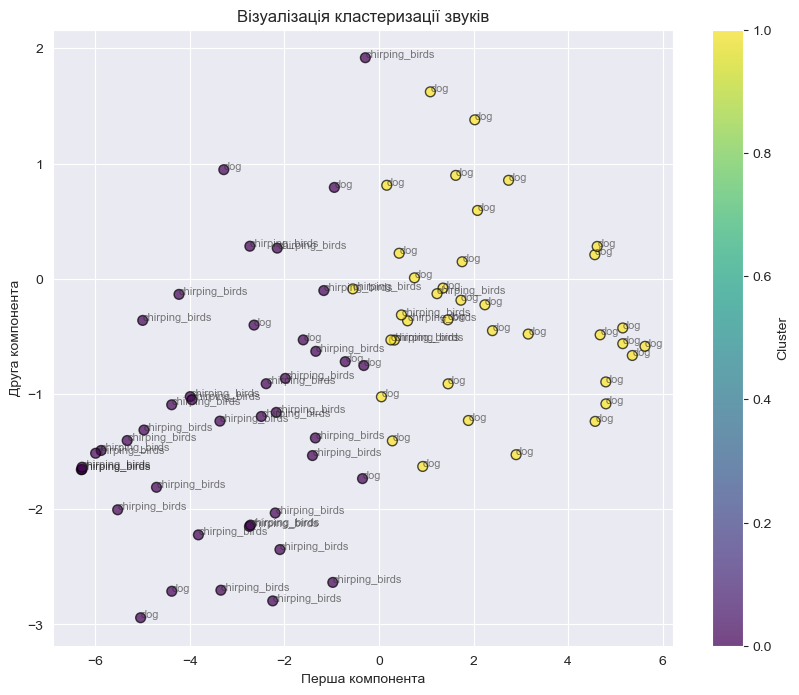

In [15]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Зниження розмірності для візуалізації
# Використовуємо t-SNE або PCA (залежить від розміру даних)
use_tsne = True  # Змініть на False, якщо хочете спробувати PCA

if use_tsne:
    reducer = TSNE(n_components=2, random_state=42, perplexity=30)
else:
    reducer = PCA(n_components=2)

# Перетворення даних у 2D-простір
reduced_features = reducer.fit_transform(feature_matrix)

# Візуалізація кластерів
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_features[:, 0], reduced_features[:, 1],
    c=clusters, cmap='viridis', s=50, alpha=0.7, edgecolors='k'
)

# Додавання міток
for i, label in enumerate(audio_labels):
    plt.annotate(label, (reduced_features[i, 0], reduced_features[i, 1]), fontsize=8, alpha=0.6)

# Декорування графіка
plt.colorbar(scatter, label='Cluster')
plt.title('Візуалізація кластеризації звуків')
plt.xlabel('Перша компонента')
plt.ylabel('Друга компонента')
plt.grid(True)
plt.show()

Оцінка кластеризації:  

1.	Кластеризація майже коректна:
* Більшість звуків класу chirping_birds потрапили в кластер 0 (34 з 40).
* Більшість звуків класу dog потрапили в кластер 1 (31 з 40).
2. Помилки кластеризації:
* 6 звуків класу chirping_birds потрапили у кластер 1 (де переважають звуки dog).
* 9 звуків класу dog потрапили у кластер 0 (де переважають звуки chirping_birds).
3.	Загальний висновок:
* Алгоритм працює добре, але є деяка плутанина між класами (помилкові класифікації).
* Це може бути пов’язано з тим, що деякі звуки класів chirping_birds і dog мають схожі частотні характеристики (наприклад, шум, високі або низькі частоти).